In [267]:
# Imports
import sqlite3 as lite
import pandas as pd
import re
import numpy as np
import ast

In [268]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

print("Amount of rows in races_df: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df: ", riders_df[riders_df.columns[0]].count())

conn.close()

"""
Convert the 'Date' column to DateTime format
Regarding races_df dataframe!
"""

races_df['Date'] = pd.to_datetime(races_df['Date'], errors='coerce', format='%d %B %Y')

# Remove rows where 'Date' is NaT
races_df = races_df.dropna(subset=['Date'])

# Normalize 'Date' to strip out time if it's present (this keeps just the date part)
races_df['Date'] = races_df['Date'].dt.normalize()

# Extract the month and year from the column and put them in their own columns
races_df['Month'] = races_df['Date'].dt.month
races_df['Year'] = races_df['Date'].dt.year

print("Unique values for 'months': ", races_df['Month'].unique(), "\n")
print("Unique values for 'years': ",races_df['Year'].unique())

"""
Converting the timetable to total seconds
"""

def time_to_seconds(time_str):
    # Remove commas and any spaces
    time_str = time_str.replace(',', '').strip()

    # Check the consistency of the time format using regular expressions
    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', time_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        total_seconds = hours * 3600 + minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan
        return total_seconds

    # Do the same as the loop above, but now for MM:SS format.
    match = re.match(r'(\d{1,2}):(\d{2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan  
        return total_seconds

    # Do the same but for 0:00, 0:01, etc.
    match = re.match(r'(\d{1,2}):(\d{1,2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan 
        return total_seconds
    
    # If format doesn't match, return NaN
    return np.nan

# Apply the conversion function to the 'Time' column
races_df['Time_seconds'] = races_df['Time'].apply(time_to_seconds)

# print(races_df[['Time', 'Time_seconds']].head(10))
# races_df.info()

"""
Converting timelag to total seconds
"""

def timelag_to_seconds(timelag_str):
    # Check if the timelag_str contains missing values
    if pd.isna(timelag_str):
        return np.nan

    timelag_str = timelag_str.lstrip('+').strip()

    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', timelag_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        return hours * 3600 + minutes * 60 + seconds

    match = re.match(r'(\d{1,2}):(\d{2})', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds
    
    match = re.match(r'(\d+):(\d+)', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds

    return np.nan

races_df['Timelag_seconds'] = races_df['Timelag'].apply(timelag_to_seconds)

races_df['Timelag_seconds'] = races_df['Timelag_seconds'].replace(0.0, np.nan)

print(races_df[['Timelag', 'Timelag_seconds']].head(10))

"""
Converting distance into single numerical value
This means stripping 'km' from string and converting the remaining values into float64
"""

races_df['Length'] = races_df['Length'].str.replace(' km', '', regex=False)

# Convert to numeric and replace 0 with NaN
races_df['Length'] = pd.to_numeric(races_df['Length'], errors='coerce')  # Convert to numeric and handle errors

# Replace 0 values with NaN
races_df['Length'] = races_df['Length'].replace(0.0, np.nan)

# print(races_df['Length'])

"""
Splitting values from 'rdr' and putting the split values into separate columns
"""

# Function to convert the 'rdr' string to separate ranking columns
def extract_rankings(rdr_str):
    try:
        # Converting str to dict
        rankings = ast.literal_eval(rdr_str)
        
        # Extracting ranks, while also handling missing keys
        pcs_rnk = rankings.get('PCS Ranking', np.nan)
        uci_rnk = rankings.get('UCI World Ranking', np.nan)
        alltime_rnk = rankings.get('Specials | All Time Ranking', np.nan)
        
        return pd.Series([pcs_rnk, uci_rnk, alltime_rnk])
    except:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply the function to the 'rdr' column
riders_df[['PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']] = riders_df['rdr'].apply(extract_rankings)

# Entries should be turned into numeric values, where errors get turned into NaN
riders_df['PCS_Rnk'] = pd.to_numeric(riders_df['PCS_Rnk'], errors='coerce')
riders_df['UCI_Rnk'] = pd.to_numeric(riders_df['UCI_Rnk'], errors='coerce')
riders_df['AllTime_Rnk'] = pd.to_numeric(riders_df['AllTime_Rnk'], errors='coerce')

# print(riders_df[['fullname', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']])

"""
Convert stage types to binary with label encoding
"""

races_df['Stage_Type_bin'] = races_df['Stage_Type'].map({'RR': 0, 'ITT': 1})

"""
Splitting values from 'pps' and putting those values into separate columns.
"""

def extract_points(pps_str):
    try:
        points = ast.literal_eval(pps_str)
        
        day_pnt = np.nan if points.get('One day races', '0') == '0' else points.get('One day races', np.nan)
        gc_pnt = np.nan if points.get('GC', '0') == '0' else points.get('GC', np.nan)
        tt_pnt = np.nan if points.get('Time trial', '0') == '0' else points.get('Time trial', np.nan)
        sprint_pnt = np.nan if points.get('Sprint', '0') == '0' else points.get('Sprint', np.nan)
        climb_pnt = np.nan if points.get('Climber', '0') == '0' else points.get('Climber', np.nan)
        
        return pd.Series([day_pnt, gc_pnt, tt_pnt, sprint_pnt, climb_pnt])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])

riders_df[['Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']] = riders_df['pps'].apply(extract_points)

riders_df['Day_Pnt'] = pd.to_numeric(riders_df['Day_Pnt'], errors='coerce')
riders_df['GC_Pnt'] = pd.to_numeric(riders_df['GC_Pnt'], errors='coerce')
riders_df['TT_Pnt'] = pd.to_numeric(riders_df['TT_Pnt'], errors='coerce')
riders_df['Sprint_Pnt'] = pd.to_numeric(riders_df['Sprint_Pnt'], errors='coerce')
riders_df['Climb_Pnt'] = pd.to_numeric(riders_df['Climb_Pnt'], errors='coerce')


Amount of rows in races_df:  225918
Amount of rows in riders_df:  1042
Unique values for 'months':  [ 1  3  4  5  6  7  8  9 10] 

Unique values for 'years':  [2012 2014 2015 2017 2018 2020 2021]
  Timelag  Timelag_seconds
0   +0:00              NaN
1   +0:04              4.0
2   +0:06              6.0
3   +0:10             10.0
4   +0:10             10.0
5   +0:10             10.0
6   +0:10             10.0
7   +0:10             10.0
8   +0:10             10.0
9   +0:10             10.0


In [269]:
print(riders_df['fullname'])

0          BARDET Romain
1        DUMOULIN Samuel
2          GALLOPIN Tony
3          NAESEN Oliver
4          FRANK Mathias
              ...       
1037      TRONDSEN Trond
1038    VAN MELSEN Kévin
1039     BEULLENS Cédric
1040    DE WINTER Ludwig
1041      DELACROIX Théo
Name: fullname, Length: 1042, dtype: object


In [270]:
riders_df['fullname'] = riders_df['fullname'].str.replace(' ', '_') 
print(riders_df['fullname'])

0          BARDET_Romain
1        DUMOULIN_Samuel
2          GALLOPIN_Tony
3          NAESEN_Oliver
4          FRANK_Mathias
              ...       
1037      TRONDSEN_Trond
1038    VAN_MELSEN_Kévin
1039     BEULLENS_Cédric
1040    DE_WINTER_Ludwig
1041      DELACROIX_Théo
Name: fullname, Length: 1042, dtype: object


In [271]:
"""
Join the rider and race tables together, using the rider_id as an index
"""
print("Amount of rows in races_df post cleanup: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df post cleanup: ", riders_df[riders_df.columns[0]].count())

df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'), how = 'left')

print("Amount of rows in df: ", df[df.columns[0]].count())

"""
Dropping columns that are not needed for analysis
"""

# Note: fix the long list
df.drop(['Time', 'Timelag', 'rdr', 'pps', 'birthdate', 'rider_url', 'Race_url', 'Stage_url', 'Circuit', 'Race_Name', 'Stage_Name', 'Start', 'Finish', 'Category', 'Stage_Type'], axis=1, inplace=True)

# Additional drops:
df = df.drop(columns=['id', 'Team', 'Date', 'Race_ID', 'Stage_Number', 'Team'])
# Replace all remaining zero values with NaN
df = df.replace(0, np.nan)

print(df.isna().sum())
print("Amount of rows in df after cleanup: ", df[df.columns[0]].count())
print("\ndone")

Amount of rows in races_df post cleanup:  80174
Amount of rows in riders_df post cleanup:  1042
Amount of rows in df:  80174
Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
UCI                77527
Pnt                69767
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64
Amount of rows in df after cleanup:  80174

done


### PI 7: Part 3


#### 1.1 Appropriate Machine Learning Models
In this section, the selection of appropriate machine learning models in the context of the current dataset will be discussed.

#### 1.2.1 Categorical and Regression Trees
For the first model, the use of Categorical and Regression Trees will be discussed. As stated in *part 2* of the assignment, CART is a decision tree, that classifies records based on the conditions in the *decision nodes*, where the final classification, or regression, is determined in the *leaf nodes*. See the code from <code>pi7-2.ipynb</code> for a more in-depth explanation of decision trees.

#### 1.2.2 Argumentation
A regression tree will be implemented due to the following reasons:
- Handling possible non-linear relationships.
- It does not require any normalization/standardization, making outcomes more interpretable.
- It can handle outliers and missing values well.

Arguments against implementing regression trees:
- The more complex a tree becomes, the more prone it becomes to overfitting. There are methods for handling scenarios where overfitting can become an issue, like *pruning*.
- Sensitive to hyperparameters.
- Unsuitable for datasets with a large number of classes (see the arguments above).

#### 1.2.3 Implementation
Below is am implementation of a regression tree on the current dataset.

In [272]:
df.isnull().sum()

Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
UCI                77527
Pnt                69767
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64

'Rnk' or final rank will be used as our predictor variable. This column still contains alot of numerical values for 'DNF', meaning this will need to get cleaned up. Removing non-numericals, like DNF, DNS and OTL, does not impact the amount of available data by a large amount, so we will result in dropping these entries. Since these entries will most likely not contain any useful information (since the rider never finished or fouled), these entries will be dropped.

In [273]:
df['Rnk'].isna().sum()

np.int64(0)

In [274]:
df['Rnk'] = pd.to_numeric(df['Rnk'], errors='coerce')

In [275]:
df['Rnk'].isna().sum()

np.int64(5219)

Regression will be used to determine the outcome rank for riders. To do this, a new dataframe will be created to define the predictors of which we think are important for the outcome rank.

In [286]:
df_ml = df.drop(columns = ['GC', 'BiB', 'UCI', 'Pnt', 'Stage_Type_bin', 'Rider', 'fullname', 'team', 'country', 'Length', 'Month', 'Year'])

df_ml.isnull().sum()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              74955 non-null  float64
 1   Age              80174 non-null  int64  
 2   Time_seconds     61739 non-null  float64
 3   Timelag_seconds  68962 non-null  float64
 4   height           45914 non-null  float64
 5   weight           45908 non-null  float64
 6   PCS_Rnk          34332 non-null  float64
 7   UCI_Rnk          33370 non-null  float64
 8   AllTime_Rnk      26874 non-null  float64
 9   Day_Pnt          45958 non-null  float64
 10  GC_Pnt           45966 non-null  float64
 11  TT_Pnt           45543 non-null  float64
 12  Sprint_Pnt       45832 non-null  float64
 13  Climb_Pnt        45809 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 11.2+ MB


In [277]:
df_ml = df_ml.dropna()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12186 entries, a73d590113699f02caf57566c20a2ae7 to 4b35e4a129ae080c4ccec66ea79e0be3
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              12186 non-null  float64
 1   Age              12186 non-null  int64  
 2   Length           12186 non-null  float64
 3   Month            12186 non-null  int32  
 4   Year             12186 non-null  int32  
 5   Time_seconds     12186 non-null  float64
 6   Timelag_seconds  12186 non-null  float64
 7   height           12186 non-null  float64
 8   weight           12186 non-null  float64
 9   PCS_Rnk          12186 non-null  float64
 10  UCI_Rnk          12186 non-null  float64
 11  AllTime_Rnk      12186 non-null  float64
 12  Day_Pnt          12186 non-null  float64
 13  GC_Pnt           12186 non-null  float64
 14  TT_Pnt           12186 non-null  float64
 15  Sprint_Pnt       12186 non-null  float64
 16  Climb

In [278]:
X = df_ml.iloc[:, 1:16] # adjust row val
y = df_ml.iloc[:, 0]

In [279]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17, test_size=0.2)

In [283]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dtr = DecisionTreeRegressor().fit(X, y)

y_pred = dtr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

accuracy:  1.0


IndexError: list index out of range

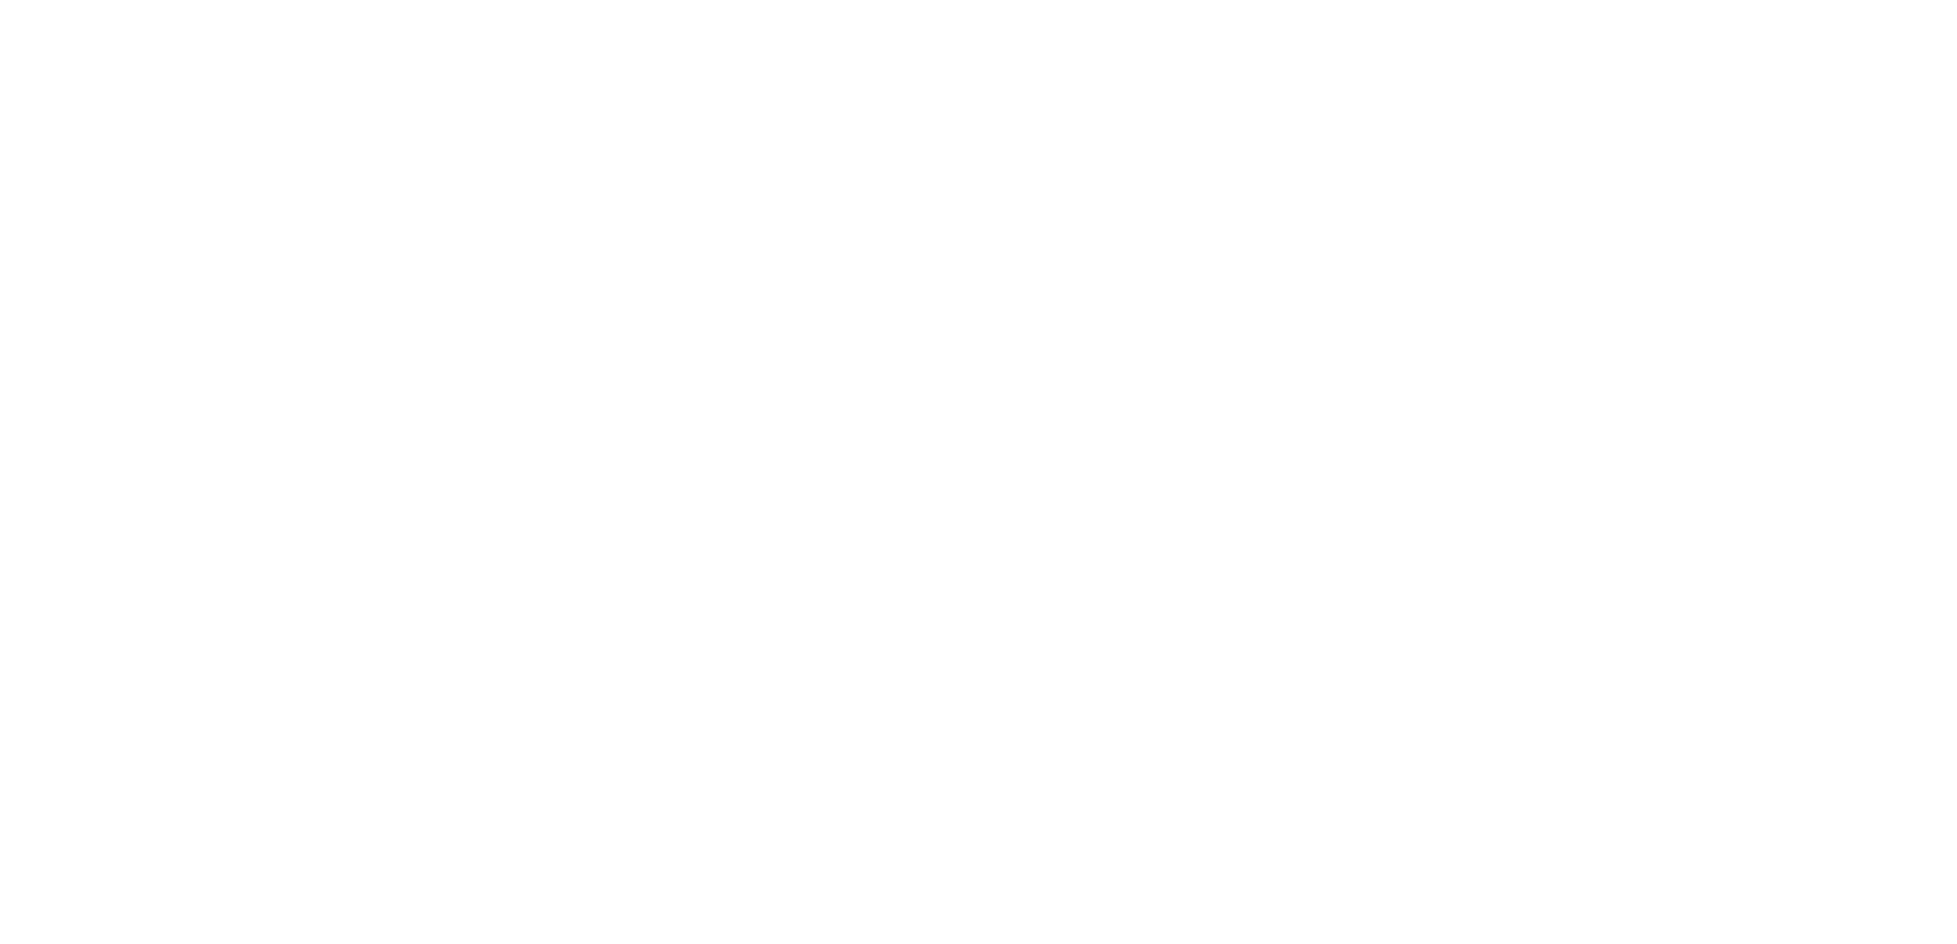

In [285]:
plt.figure(figsize=(25,12))
plot_tree(dtr, fontsize=8, feature_names=[])
plt.show()

In [234]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [235]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [237]:
y_pred = dtc.predict(X_test)

In [238]:
from sklearn.metrics import confusion_matrix 

print(confusion_matrix(y_test, y_pred))

[[37  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [239]:
from sklearn.metrics import classification_report
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

# Due to the large number of objects, overall accuracy score is used
# print(classification_report(y_test, y_pred, zero_division=0)) 

accuracy:  0.030762920426579164


In [240]:
features = pd.DataFrame(dtc.feature_importances_, index= X.columns)

features.head(15)

,0
Age,0.070368
Length,0.152299
Month,0.072501
Year,0.052624
Time_seconds,0.165356
Timelag_seconds,0.155269
height,0.029954
weight,0.034622
PCS_Rnk,0.035724
UCI_Rnk,0.035807


In [241]:
dtc2 = DecisionTreeClassifier(criterion= 'entropy', ccp_alpha = 0.04)

dtc2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.04, criterion='entropy')

In [242]:
y_pred2 = dtc2.predict(X_test)
print(confusion_matrix(y_test, y_pred2))

[[35  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [ ]:
#print(classification_report(y_test, y_pred2, zero_division=0))
accuracy = accuracy_score(y_test, y_pred2)
print("accuracy: ", accuracy)

accuracy:  0.02461033634126333


In [244]:
features2 = (pd.DataFrame(dtc2.feature_importances_, index=X.columns))
features2.head(15)

,0
Age,0.000000
Length,0.000000
Month,0.000000
Year,0.000000
Time_seconds,0.730321
Timelag_seconds,0.000000
height,0.000000
weight,0.000000
PCS_Rnk,0.000000
UCI_Rnk,0.000000


In [245]:
new_data = pd.DataFrame({'Age': [25], 'Length': [100], 'Month': [6], 'Year': [2022], 'Time_seconds': [3600], 'Timelag_seconds': [0], 'height': [180], 'weight': [70], 'PCS_Rnk': [10], 'UCI_Rnk': [20], 'AllTime_Rnk': [30], 'Day_Pnt': [40], 'GC_Pnt': [50], 'TT_Pnt': [60], 'Sprint_Pnt': [70]})

# Use the DTC model to make a prediction
prediction = dtc.predict(new_data)

# Print the prediction
print(prediction)

[127.]


#### 1.2.4 Boosted Forest

#### 1.3 Gradient Boosting


In [249]:
y_test, y_train

(rider_id
 3397edbe10fdce2e38db0e4c9c253dad     51.0
 4b35e4a129ae080c4ccec66ea79e0be3    186.0
 98430c31927e1578acdcd383bab94dbb     67.0
 1dccfb04007c206da981d90978e2ee89     96.0
 e9b1a932c94dca07893dfede5eb12903    145.0
                                     ...  
 f1bd86cc6567c0dfa5721dce45d35e7e     56.0
 7d63fc210f1790a5b6a6d0fc3035e527     86.0
 d7e19a4f12a14a449d21900e818770ce     35.0
 ec94bc38e5f69ba0697bea8b47a9db10     14.0
 8ca4cfaf07a8e357bbcfbffbf2061b25     69.0
 Name: Rnk, Length: 2438, dtype: float64,
 rider_id
 1a1e24868c09fa2a54922a0fefdf4465    121.0
 c8220dbd975ae82181f98722000b662f     42.0
 5dbb77082695488e013574823562ec57     76.0
 7022fe00f5237209e9f58e8e7fff0446     50.0
 6b9154d3754796dd73e1ae2d5b27304b     75.0
                                     ...  
 22ef922b9767ce9d54e13c67bfd807ec     39.0
 64ce81af9f1e95f2417c7b761426b157     50.0
 db2d18b40afeb8ab98c08f7f6c19ddfc     32.0
 4485ac2bf252ae4395f1b850fa9e2c76     57.0
 783f549f704a01c53c60ffc3e40910d5  

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#clf = HistGradientBoostingClassifier().fit(X, y)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.004101722723543888

In [251]:
accuracy_gb = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_gb)

Accuracy:  0.030762920426579164


The number of regression trees is controlled by n_estimators. 
The size of each tree can be controlled either by setting the tree depth via max_depth or by setting the number of leaf nodes via max_leaf_nodes. The learning_rate is a hyper-parameter in the range (0.0, 1.0) that controls overfitting via shrinkage.

#### Source:

*Ensembles: Gradient boosting, random forests, bagging, voting, stacking.* (2022). Scikit-Learn. https://scikit-learn.org/stable/modules/ensemble.html#gradientboostingclassifier-and-gradientboostingregressor

‌

#### 1.4 Support Vector Regression (SVR)

#### 2.1 Metrics for Models

#### 3.1 Cross-validation

#### 4.1 Ideal Hyperparameters

#### 5.1 Conclusions

#### Bibliography